## Notebook setup

In [1]:
library(tidyverse)
library(arcadiathemeR)
library(ggforce)
library(patchwork)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading Suisse fonts...



All custom fonts 'Suisse Int'l, Suisse Int'l Semi Bold, Suisse Int'l Medium, Suisse Int'l Mono' are successfully loaded.


In [2]:
setwd("..")

In [25]:
# adjust plot size rendered inline
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 200)

## Set plotting parameters

In [3]:
CANDY <- c("#E2718F")
REGULAR_FONT <- "Suisse Int'l"
CATEGORICAL_FONT <- REGULAR_FONT

## Read in data

In [5]:
viro3d <- read_csv("inputs/viral/foldseekCluster90_1E-5_meta.csv", show_col_types = FALSE)

In [7]:
metadata <- read_tsv("benchmarking_data/controls/control_metadata.tsv", show_col_types = FALSE) %>%
  mutate(structure_file = str_remove(string = structure_file, pattern = ".pdb"))

In [8]:
column_types <- cols(.default = col_character(), qlen = col_double(), tlen = col_double(),
                     alnlen = col_double(), alntmscore = col_double(), qtmscore = col_double(),
                     ttmscore = col_double(), lddt = col_double(), prob = col_double(),
                     qcov = col_double(), tcov = col_double(), pident = col_double(),
                     bits = col_double(), evalue = col_double(), qstart = col_double(),
                     qend = col_double(), tstart = col_double(), tend = col_double(),
                     proteinatlas_chromosome = col_character(),
                     host_fragment = col_logical(), host_redox_potential = col_logical(),
                     host_temperature_dependence = col_logical(), host_fragment_1 = col_logical(),
                     host_gene_encoded_by = col_logical())

In [9]:
results <- Sys.glob("outputs/human/foldseek/*/processed/*tmscorethreshold0.tsv") %>%
  set_names() %>%
  map_dfr(~ read_tsv(.x, col_types = column_types, show_col_types = FALSE), .id = "filepath") %>%
  mutate(filepath = str_remove(string = filepath, pattern = "outputs/human/foldseek/"),
         filepath = str_remove(string = filepath, pattern = "processed/foldseek_"),
         filepath = str_remove(string = filepath, pattern = "_tmalignfast0_exacttmscore1_tmscorethreshold0.tsv")) %>%
  separate(col = filepath, into = c("mimic", "alignment_type"), sep = "/", remove = TRUE) %>%
  mutate(alignment_type = ifelse(alignment_type == "alignmenttype1", "TM-align", "3Di+AA")) %>%
  left_join(metadata, by = c("query" = "structure_file")) %>%
  left_join(viro3d, by = c("viro3d_filename" = "cluster_member")) %>%
  mutate(neg_log_evalue = -log10(if_else(evalue == 0, 1e-300, evalue)))

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Warning message:
“One or mo

## Apply to controls that mimic one known human protein

In [10]:
single_mimic <- results %>%
  filter(mimic_type == "single_mimic") %>%
  mutate(correct = ifelse(target == target_uniprot, "correct hit", "off-target hit")) %>%
  filter(!mimic %in% "c1l") %>%
  mutate(mimic_cluster = paste0(mimic, "_", cluster_id))

In [11]:
qtmscore_plot <- ggplot(single_mimic, aes(x = mimic_and_cluster_id, y = qtmscore)) +
  geom_sina(alpha = 1, size = 0.1) +
  geom_point(data = single_mimic %>% filter(correct == "correct hit"),
             size = 2, shape = 15, color = CANDY) +
  theme_arcadia(x_axis_type = "categorical") +
  facet_wrap(~alignment_type, ncol = 2) +
  theme(strip.text = element_text(family = CATEGORICAL_FONT, size = 15),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) +
  labs(y = "Query TM-score", x = "Mimic + Viro3D cluster")

In [12]:
ttmscore_plot <- ggplot(single_mimic, aes(x = mimic_and_cluster_id, y = ttmscore)) +
  geom_sina(alpha = 1, size = 0.1) +
  geom_point(data = single_mimic %>% filter(correct == "correct hit"),
             size = 2, shape = 15, color = CANDY) +
  theme_arcadia(x_axis_type = "categorical") +
  facet_wrap(~alignment_type, ncol = 2) +
  theme(strip.text = element_text(family = CATEGORICAL_FONT, size = 15),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) +
  labs(y = "Target TM-score", x = "Mimic + Viro3D cluster")

In [13]:
neg_log_evalue_plot <- ggplot(single_mimic %>% filter(alignment_type == "3Di+AA"),
       aes(x = mimic_and_cluster_id, y = neg_log_evalue)) +
  geom_sina(alpha = 1, size = 0.1) +
  geom_point(data = single_mimic %>% 
               filter(correct == "correct hit") %>%
               filter(alignment_type == "3Di+AA"),
             size = 2, shape = 15, color = CANDY) +
  theme_arcadia(x_axis_type = "categorical") +
  facet_wrap(~alignment_type, ncol = 2) +
  theme(strip.text = element_text(family = CATEGORICAL_FONT, size = 15),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) +
  labs(y = "Negative log of E-value", x = "Mimic + Viro3D cluster")

In [14]:
alnlen_plot <- ggplot(single_mimic, aes(x = mimic_and_cluster_id, y = alnlen)) +
  geom_sina(alpha = 1, size = 0.1) +
  geom_point(data = single_mimic %>% filter(correct == "correct hit"),
             size = 2, shape = 15, color = CANDY) +
  theme_arcadia(x_axis_type = "categorical") +
  facet_wrap(~alignment_type, ncol = 2) +
  theme(strip.text = element_text(family = CATEGORICAL_FONT, size = 15),
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) +
  labs(y = "Alignment length", x = "Mimic + Viro3D cluster")

## Calculate z scores

In [15]:
calculate_z_scores_by_group <- function(data, column, group_by_column) {
  data %>%
    group_by(!!sym(group_by_column)) %>%
    mutate(!!paste0(column, "_z") := ( !!sym(column) - mean(!!sym(column), na.rm = TRUE)) / sd(!!sym(column), na.rm = TRUE)) %>%
    ungroup()
}

In [16]:
metrics <- c("qtmscore", "alnlen", "ttmscore", "neg_log_evalue")
tmp <- single_mimic %>% mutate(correct_hit = correct == "correct hit")
for(metric in metrics) {
  tmp <- calculate_z_scores_by_group(tmp, metric, "alignment_type")
}

In [17]:
correct_hits_z_scores <- tmp %>%
  filter(correct_hit) %>%
  select(mimic, alignment_type, ends_with("_z"))

In [18]:
correct_hits_z_scores_long <- correct_hits_z_scores %>%
  pivot_longer(cols = ends_with("_z"), names_to = "metric", values_to = "z_score") %>%
  mutate(metric = gsub("_z", "", metric)) %>%
  # replace TM-align neg log evalue z score with NA since a tmscore is reported in this column
  mutate(z_score = ifelse(alignment_type == "TM-align" & metric == "neg_log_evalue", NA, z_score))

In [19]:
metric_labels <- c(
  alnlen = "Alignment length",
  qtmscore = "Query TM-score",
  ttmscore = "Target TM-score",
  neg_log_evalue = "Negative log of E-value"
)

In [20]:
zscore_plot <- ggplot(correct_hits_z_scores_long, aes(x = z_score)) +
  geom_histogram(bins = 30, alpha = 0.6) +
  geom_vline(xintercept = c(-1.96, 1.96), linetype = "dashed", color = CANDY) +
  facet_grid(cols = vars(metric),
             rows = vars(alignment_type),
             labeller = labeller(metric = metric_labels)) +
  labs(title = "Distribution of Z-scores for Correct Hits by Alignment Type",
       x = "Z-score",
       y = "Count") +
  theme_arcadia() +
  theme(legend.position = "bottom",
        plot.title.position = "plot", 
        strip.text = element_text(family = CATEGORICAL_FONT, size = 15))

In [21]:
top_row <- (alnlen_plot + neg_log_evalue_plot + qtmscore_plot + ttmscore_plot) +
  plot_layout(ncol = 2)

final_plot <- top_row / zscore_plot + 
  plot_layout(heights = c(4, 1))

Warning message:
“Removed 26 rows containing non-finite outside the scale range (`stat_bin()`).”


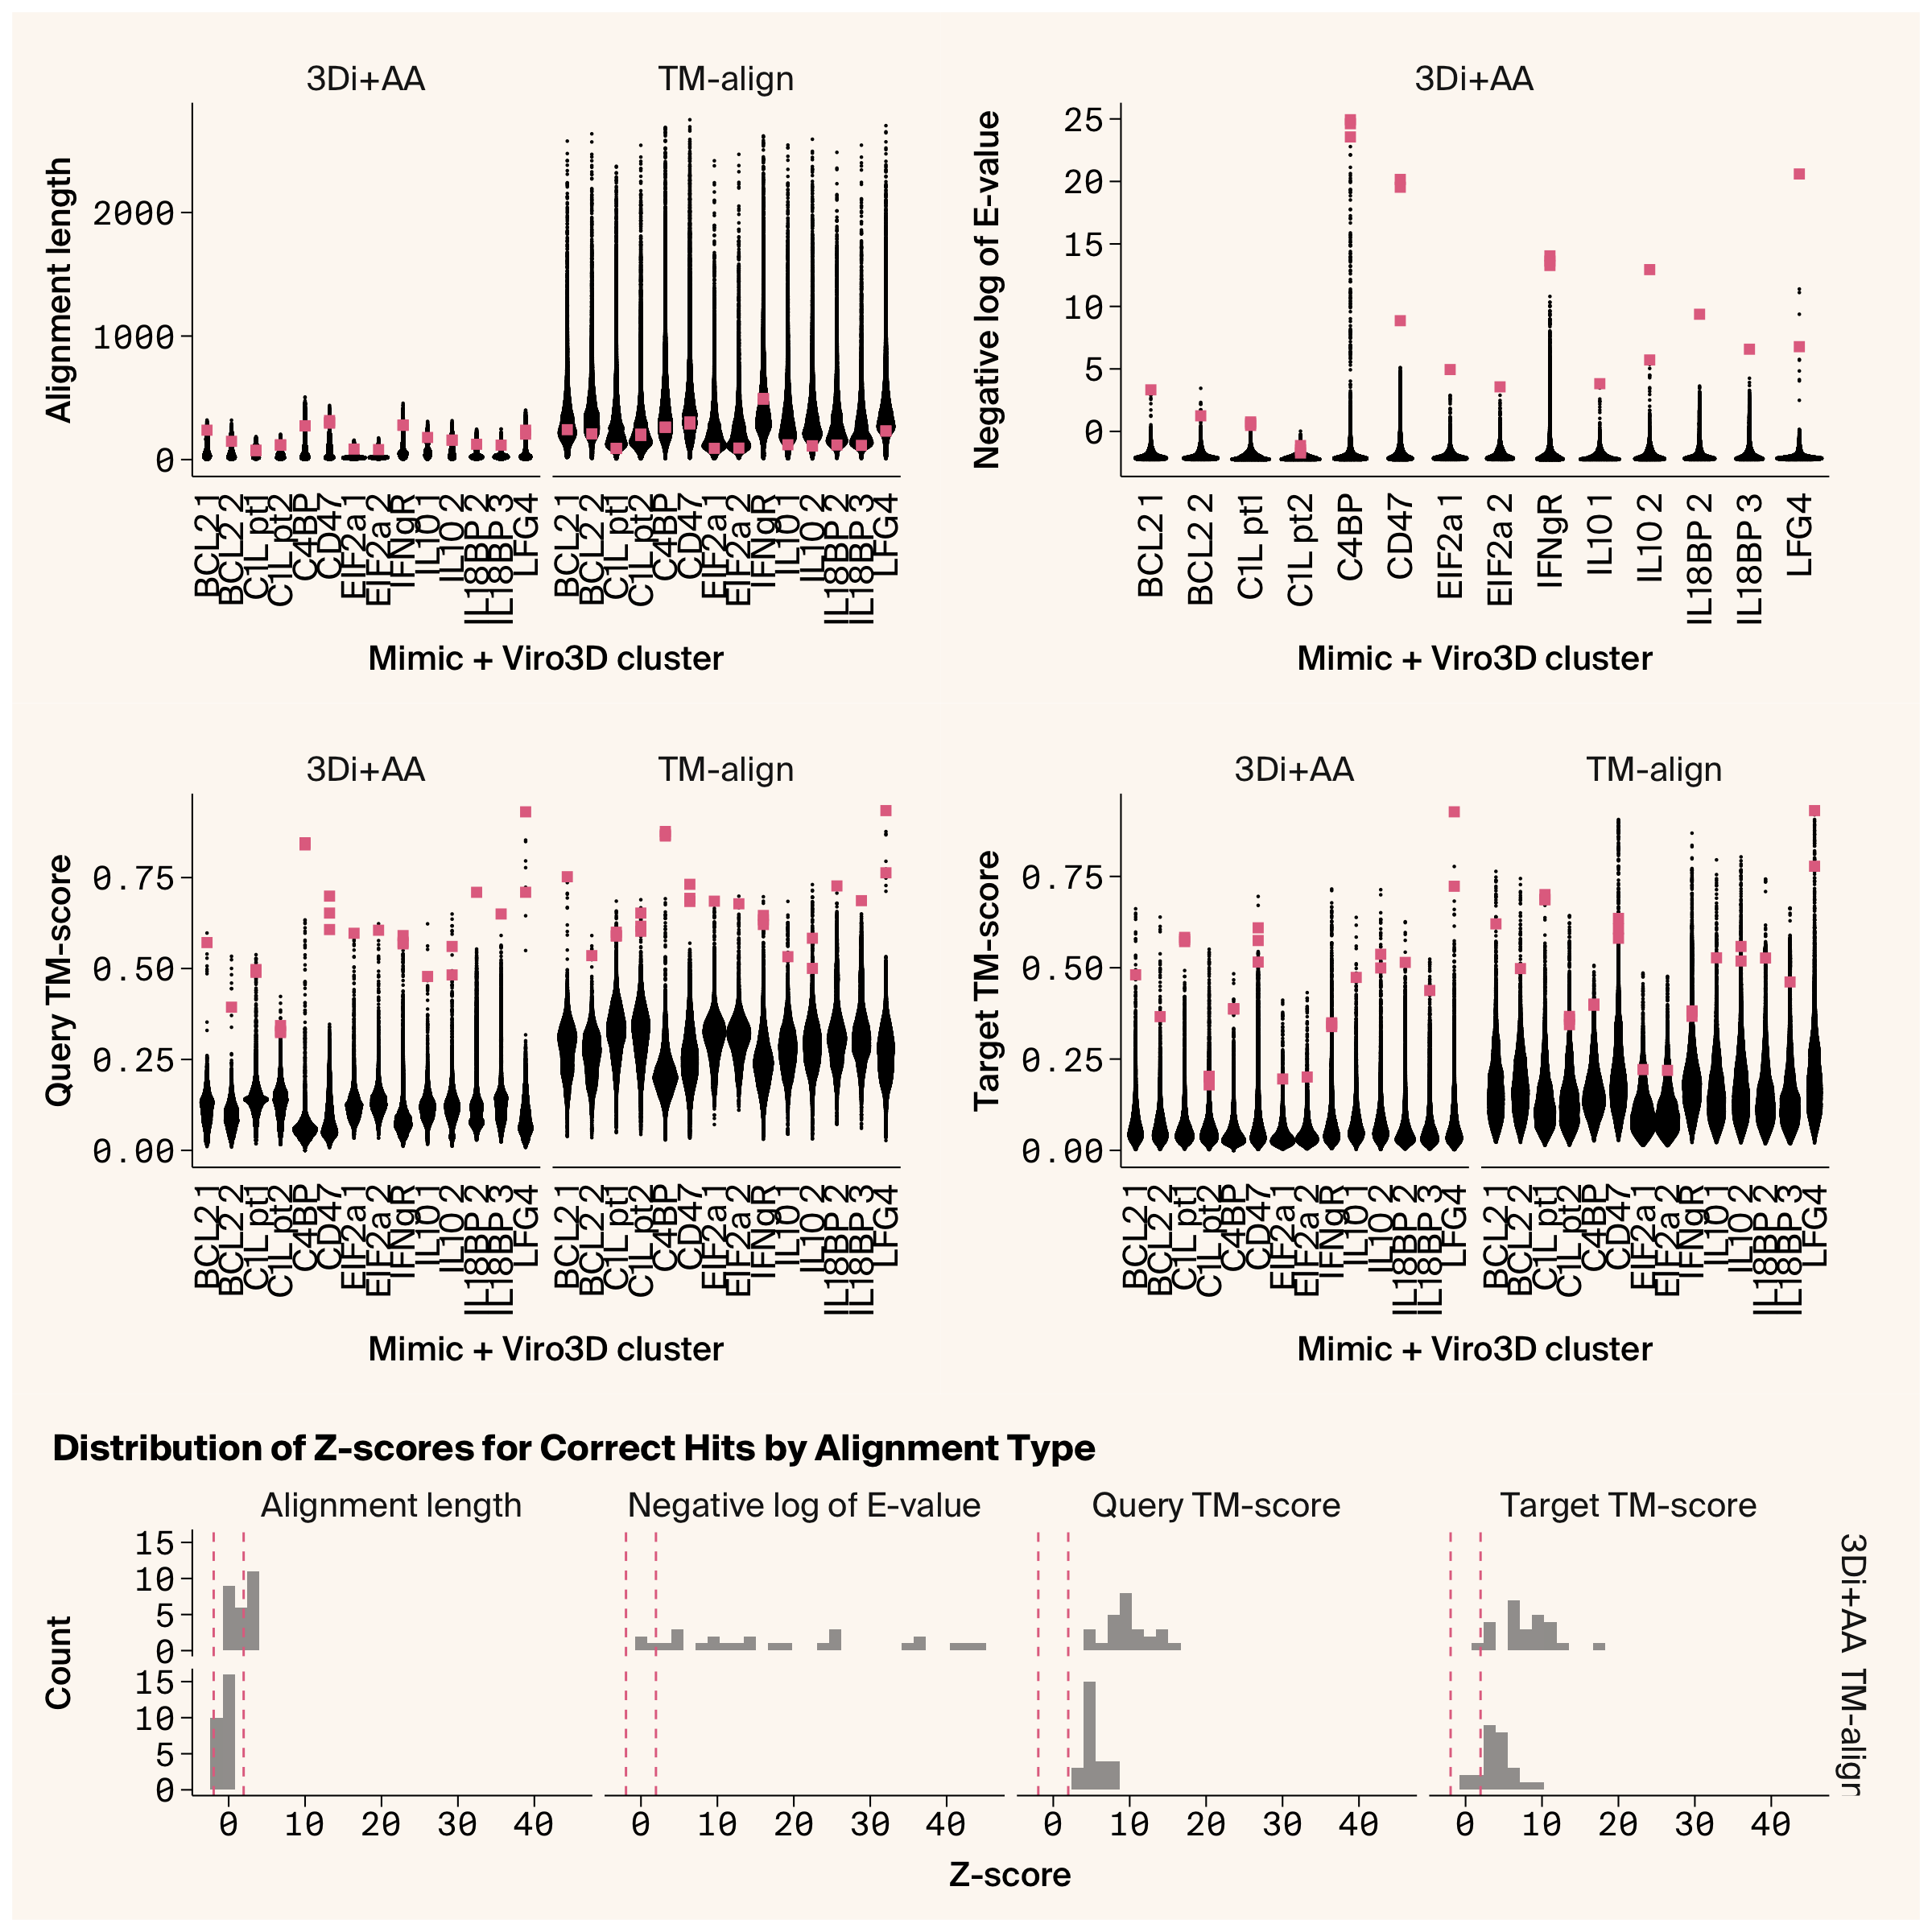

In [26]:
final_plot

In [27]:
sessionInfo()

R version 4.4.3 (2025-02-28)
Platform: x86_64-apple-darwin13.4.0
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/tidyjupyter/lib/libopenblasp-r0.3.29.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] patchwork_1.3.0     ggforce_0.4.2       arcadiathemeR_0.1.0
 [4] lubridate_1.9.4     forcats_1.0.0       stringr_1.5.1      
 [7] dplyr_1.1.4         purrr_1.0.4         readr_2.1.5        
[10] tidyr_1.3.1         tibble_3.2.1        ggplot2_3.5.2      
[13] tidyverse_2.0.0    

loaded via a namespace (and not attached):
 [1] generics_0.1.3    stringi_1.8.7     extrafontdb_1.0   hms_1.1.3        
 [5] digest_0.6.37     magrittr_2.0.3    evaluate_1.0.3    grid_4.4.3       
 [9] timecha